In [1]:
import scanpy as sc
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [2]:
train_data_file = '../data/exercise_files/train.h5ad'
test_data_file = '../data/exercise_files/test.h5ad'

In [3]:
adata_train = sc.read_h5ad(train_data_file)
adata_test = sc.read_h5ad(test_data_file)
adata_train.X = adata_train.X.toarray()
adata_train.layers['counts'] = adata_train.X
adata_test.X = adata_test.X.toarray()
adata_test.layers['counts'] = adata_test.X

In [4]:
print(adata_train.shape)
print(adata_test.shape)

(7000, 27037)
(7000, 27037)


In [5]:
adata_train.obs.head()

,cell_type,original_cell_type
run_4_PC-12D.ACTTCCGTTAGTAACGGTC-0,Placodal ectoderm,Placodal area
run_21_PB-02H_S112.TGCGTAGTTCGAGCTGCCA-10,Hindgut,Midgut/Hindgut epithelial cells
run_14_PX-06G_S143.GCTTCTGGTTTCTTAATAA-2,Dorsal spinal cord progenitors,Spinal cord dorsal progenitors
run_16_PC-10C_S267.AAAGCTGATTTTACGATGAA-4,Hindgut,Gut
run_4_PE-02C.ACGCTTATATTGACGCTCCG-0,Midbrain/Hindbrain boundary,Posterior roof plate


In [6]:
adata_train.layers['X_previous'].shape

(7000, 27037)

In [7]:
training_label_counts = adata_train.obs['cell_type'].value_counts()
test_label_counts = adata_test.obs['cell_type'].value_counts()
merged_label_counts = pd.merge(training_label_counts, test_label_counts, on='cell_type', suffixes=['_train', '_test'])

In [8]:
merged_label_counts.index

CategoricalIndex(['MEP', 'Venous endothelium', 'Spinal cord progenitors',
                  'Cardiomyocytes SHF 2', 'Late dorsal forebrain progenitors',
                  'Midbrain progenitors', 'Erythroid', 'Optic vesicle',
                  'Early dorsal forebrain progenitors', 'Foregut', 'Hindgut',
                  'Surface ectoderm', 'Cardiomyocytes FHF 1',
                  'Dorsal midbrain neurons', 'Blood progenitors',
                  'Endocardium', 'Otic neural progenitors',
                  'Intermediate mesoderm', 'Midbrain/Hindbrain boundary',
                  'Migratory neural crest', 'Kidney primordium', 'Notochord',
                  'Limb mesoderm', 'Otic placode', 'Amniotic ectoderm',
                  'Placodal ectoderm', 'Ventral hindbrain progenitors',
                  'Sclerotome', 'Haematoendothelial progenitors',
                  'Frontonasal mesenchyme', 'Dorsal spinal cord progenitors',
                  'EMP', 'NMPs/Mesoderm-biased', 'Hindbrain floor pla

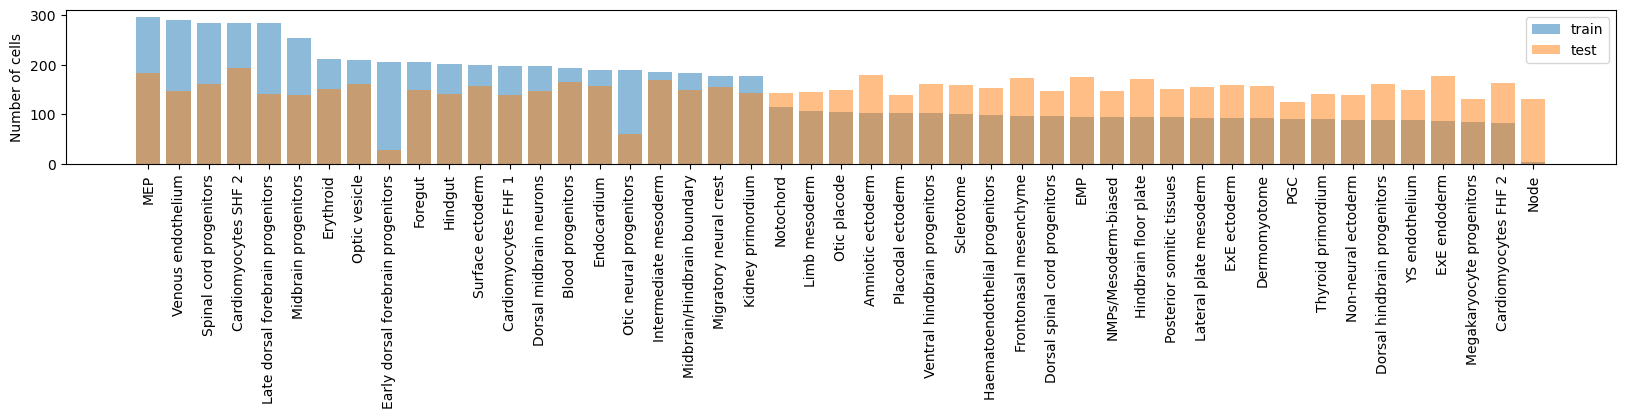

In [9]:
plt.figure(figsize=(20,2))
plt.bar(merged_label_counts.index, merged_label_counts['count_train'],alpha=0.5, label='train')
plt.bar(merged_label_counts.index, merged_label_counts['count_test'], alpha=0.5, label='test')
plt.ylabel("Number of cells")
plt.legend()
plt.xticks(rotation=90)
plt.show()

In [10]:
annot = sc.queries.biomart_annotations('mmusculus', ['ensembl_gene_id', 'external_gene_name']).set_index('ensembl_gene_id')

In [11]:
adata_train.var[annot.columns] = annot
adata_train.var['external_gene_name'] = adata_train.var['external_gene_name'].astype(str)
adata_train.var['mt'] = adata_train.var['external_gene_name'].str.startswith("mt-").astype(bool)
adata_train = adata_train[:, ~adata_train.var['mt'].isnull()]

adata_test.var[annot.columns] = annot
adata_test.var['external_gene_name'] = adata_test.var['external_gene_name'].astype(str)
adata_test.var['mt'] = adata_test.var['external_gene_name'].str.startswith("mt-").astype(bool)
adata_test = adata_test[:, ~adata_test.var['mt'].isnull()]

In [12]:
(adata_test.var_names == adata_train.var_names).sum()

np.int64(27037)

In [13]:
print(np.sum(adata_train.X==0))
print(adata_train.X.size)

176535375
189259000


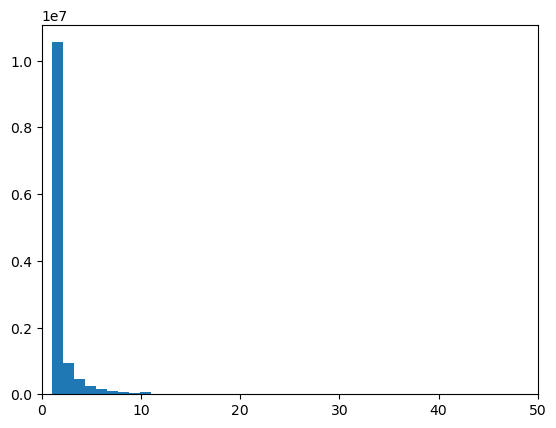

In [14]:
plt.hist(adata_train.X[adata_train.X!=0].flatten(), bins=1024)
plt.xlim(0,50)
plt.show()

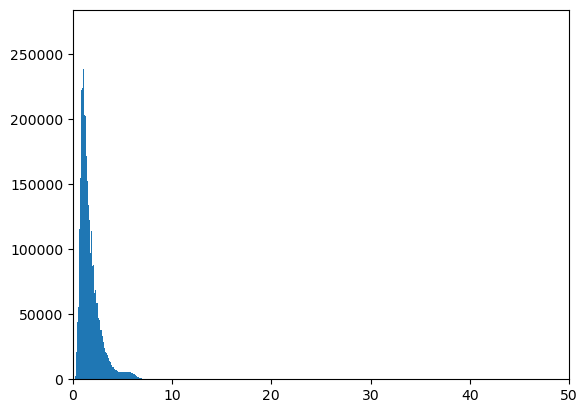

In [15]:
plt.hist(adata_test.X[adata_test.X!=0].flatten(), bins=1024)
plt.xlim(0,50)
plt.show()

In [16]:
adata_train.layers["counts"] = adata_train.X.copy()
adata_train.var_names = adata_train.var['external_gene_name']
adata_train.var_names_make_unique()
sc.pp.calculate_qc_metrics(adata_train, qc_vars='mt', inplace=True, log1p=False)

adata_test.layers["counts"] = adata_test.X.copy()
adata_test.var_names = adata_test.var['external_gene_name']
adata_test.var_names_make_unique()
sc.pp.calculate_qc_metrics(adata_test, qc_vars='mt', inplace=True, log1p=False)

/var/folders/yw/486n_std62vfzrxvh1t8_94m0000gn/T/ipykernel_49432/4266442300.py:1: ImplicitModificationWarning: Setting element `.layers['counts']` of view, initializing view as actual.
  adata_train.layers["counts"] = adata_train.X.copy()
/var/folders/yw/486n_std62vfzrxvh1t8_94m0000gn/T/ipykernel_49432/4266442300.py:6: ImplicitModificationWarning: Setting element `.layers['counts']` of view, initializing view as actual.
  adata_test.layers["counts"] = adata_test.X.copy()


In [17]:
(adata_train.var_names == adata_test.var_names).sum()

np.int64(27037)

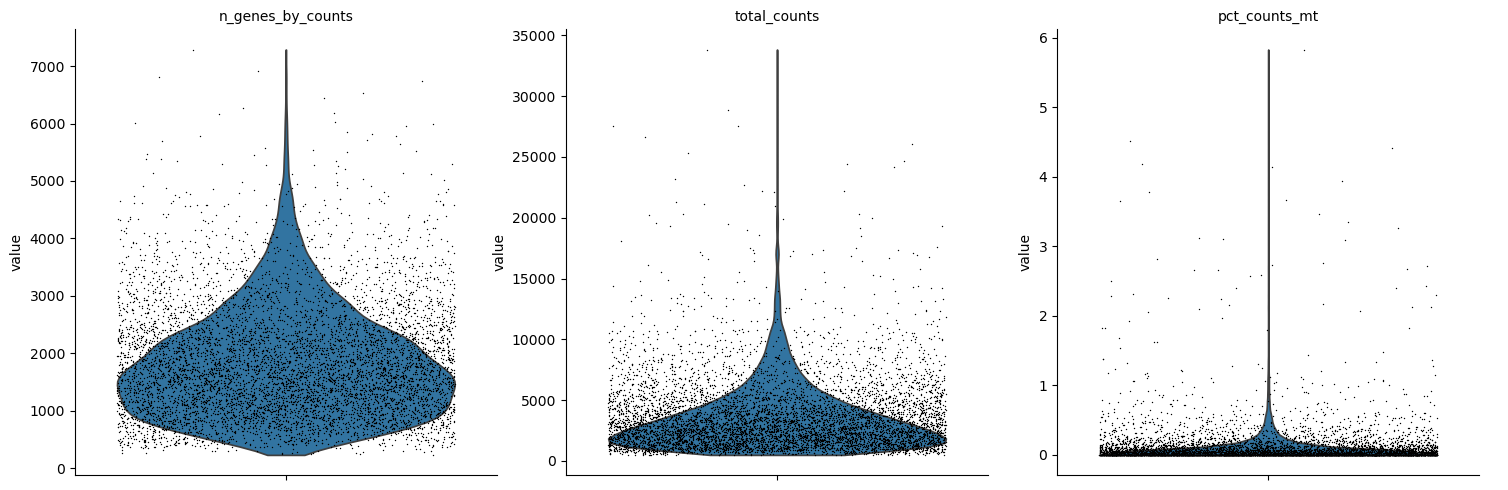

In [18]:
sc.pl.violin(
    adata_train,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

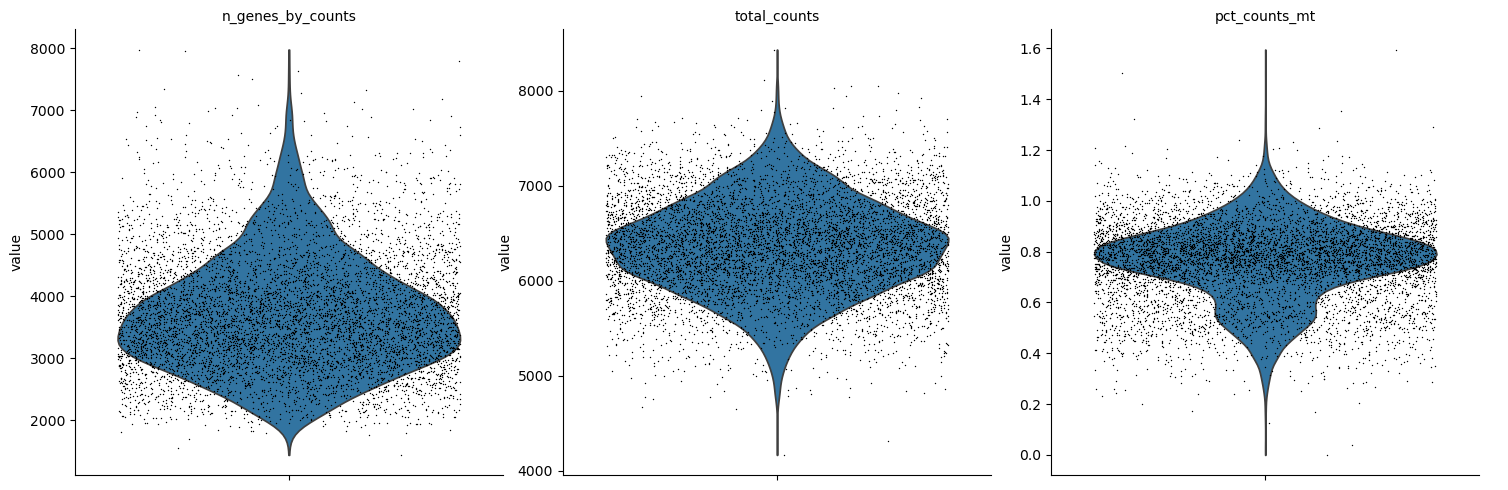

In [19]:
sc.pl.violin(
    adata_test,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

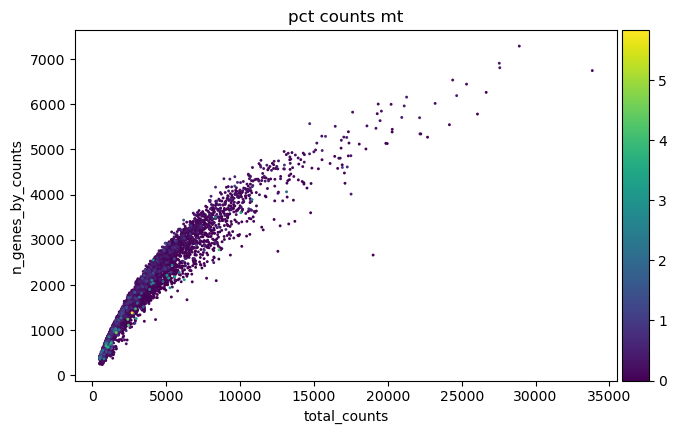

In [20]:
sc.pl.scatter(adata_train, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

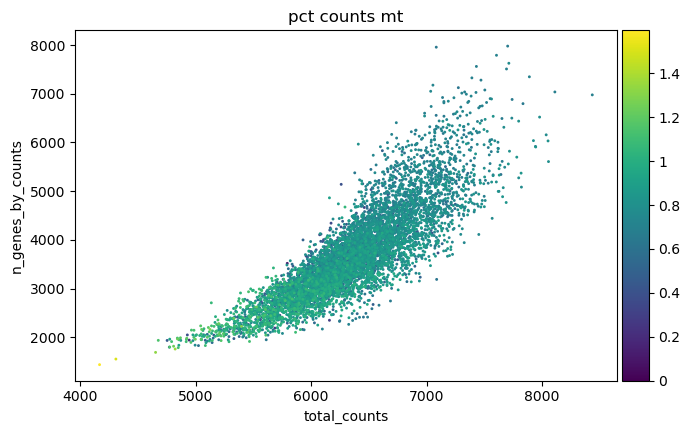

In [21]:
sc.pl.scatter(adata_test, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

In [22]:
sc.pp.scrublet(adata_train)
sc.pp.normalize_total(adata_train)
sc.pp.log1p(adata_train)

sc.pp.scrublet(adata_test)
sc.pp.normalize_total(adata_test)
sc.pp.log1p(adata_test)

In [23]:
print(adata_train.X[adata_train.X==0].size)
print(adata_train.X.size)

176535375
189259000


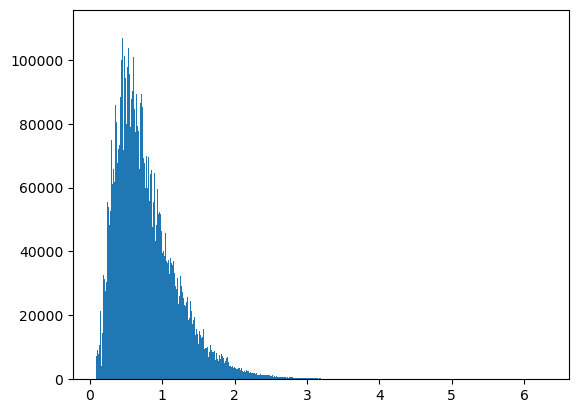

In [24]:
plt.hist(adata_train.X[adata_train.X!=0].flatten(), bins=1024)
plt.show()

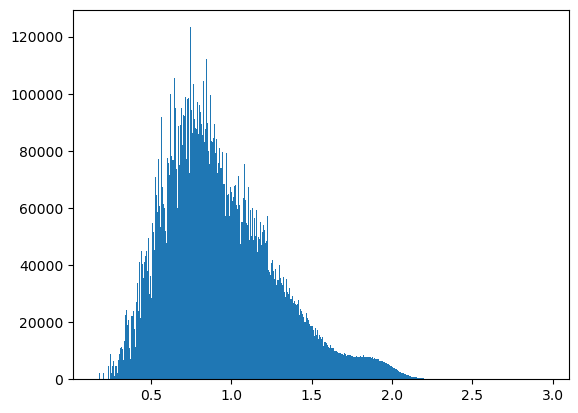

In [25]:
plt.hist(adata_test.X[adata_test.X!=0].flatten(), bins=1024)
plt.show()

/var/folders/yw/486n_std62vfzrxvh1t8_94m0000gn/T/ipykernel_49432/1196727119.py:5: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


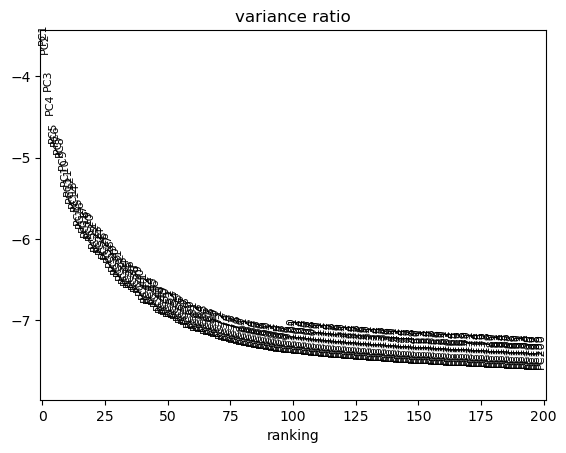

In [26]:
n_comps = 200
sc.tl.pca(adata_train, n_comps=n_comps)
fig = sc.pl.pca_variance_ratio(adata_train, n_pcs=n_comps, log=True, show=False)
fig = plt.gcf()
plt.tight_layout()

In [27]:
sc.pp.neighbors(adata_train)
sc.tl.umap(adata_train)

sc.pp.neighbors(adata_test)
sc.tl.umap(adata_test)

/Users/easwaranramamurthy/miniforge3/envs/cell-type-classification/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/easwaranramamurthy/miniforge3/envs/cell-type-classification/lib/python3.13/site-packages/scanpy/tools/_utils.py:40: UserWarning: You’re trying to run this on 27037 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  warnings.warn(


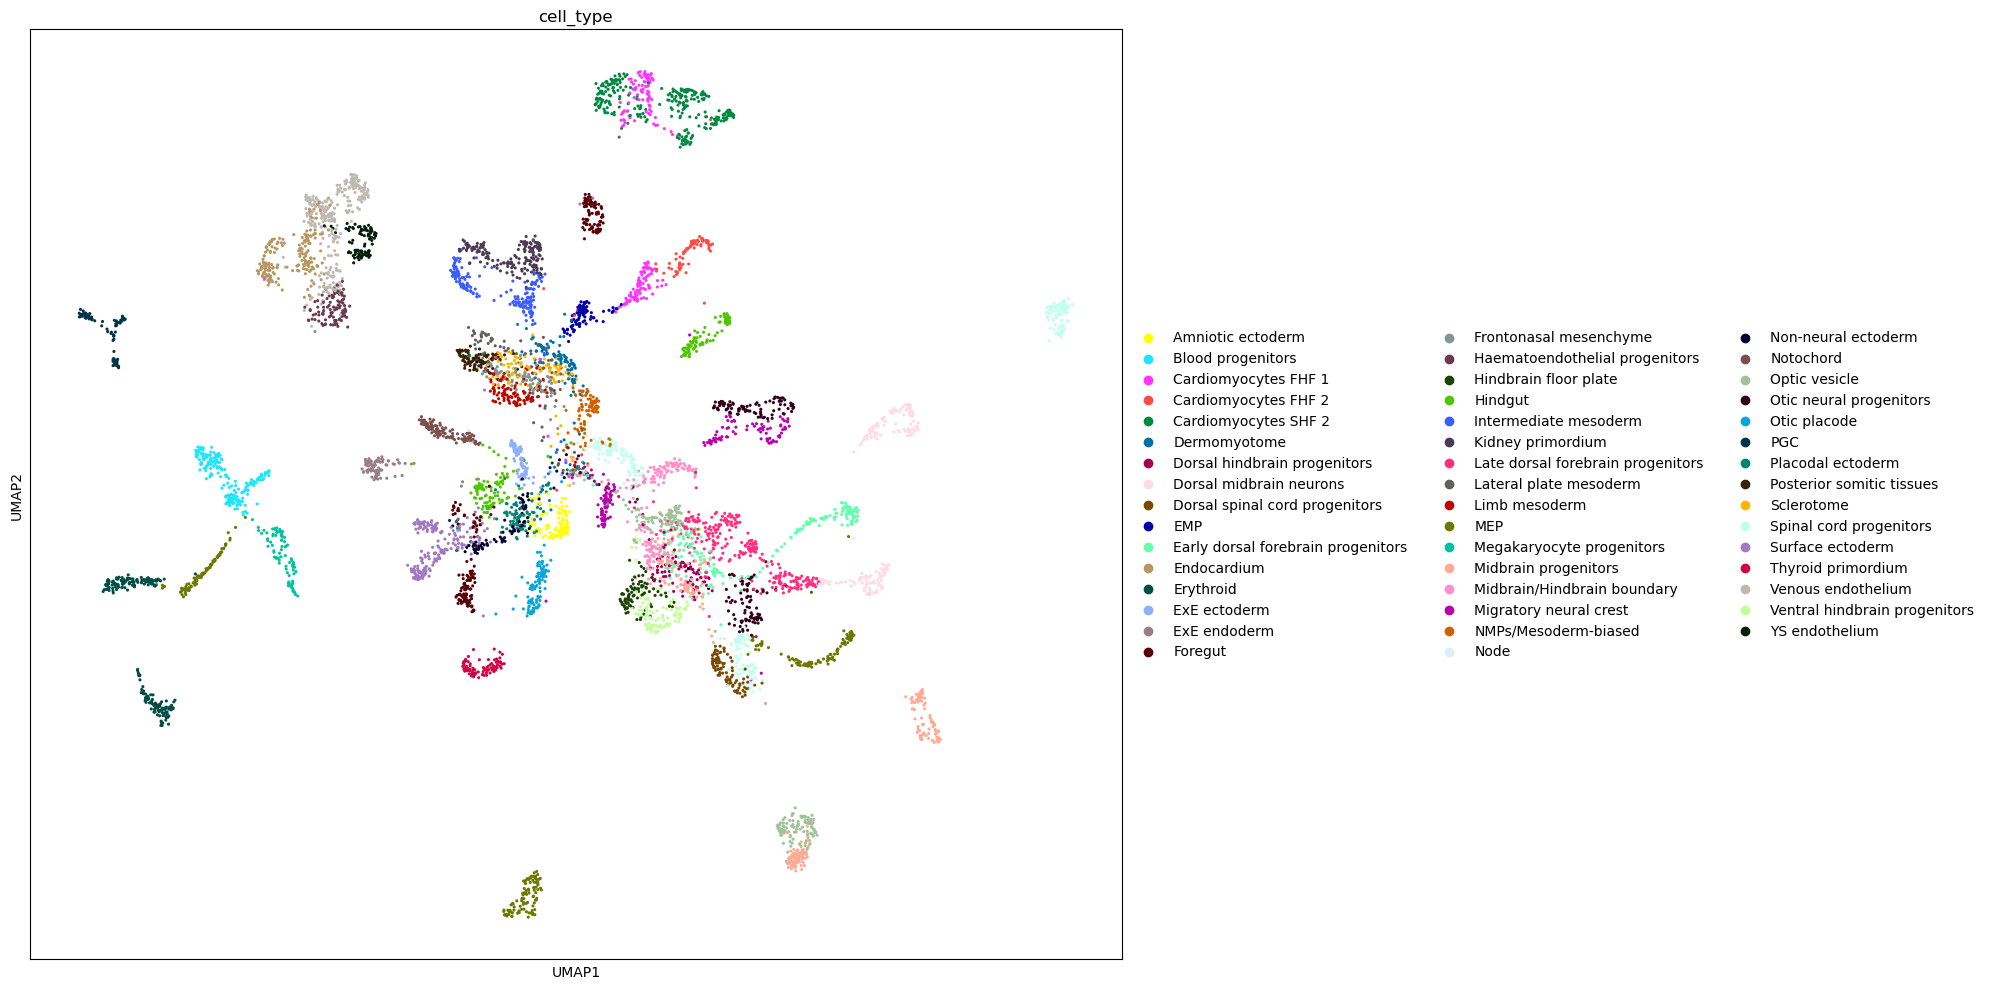

In [28]:
fig = sc.pl.umap(
    adata_train,
    color="cell_type",
    size=20,
    show=False
)
fig = plt.gcf()
fig.set_figheight(10)
fig.set_figwidth(20)

plt.tight_layout()

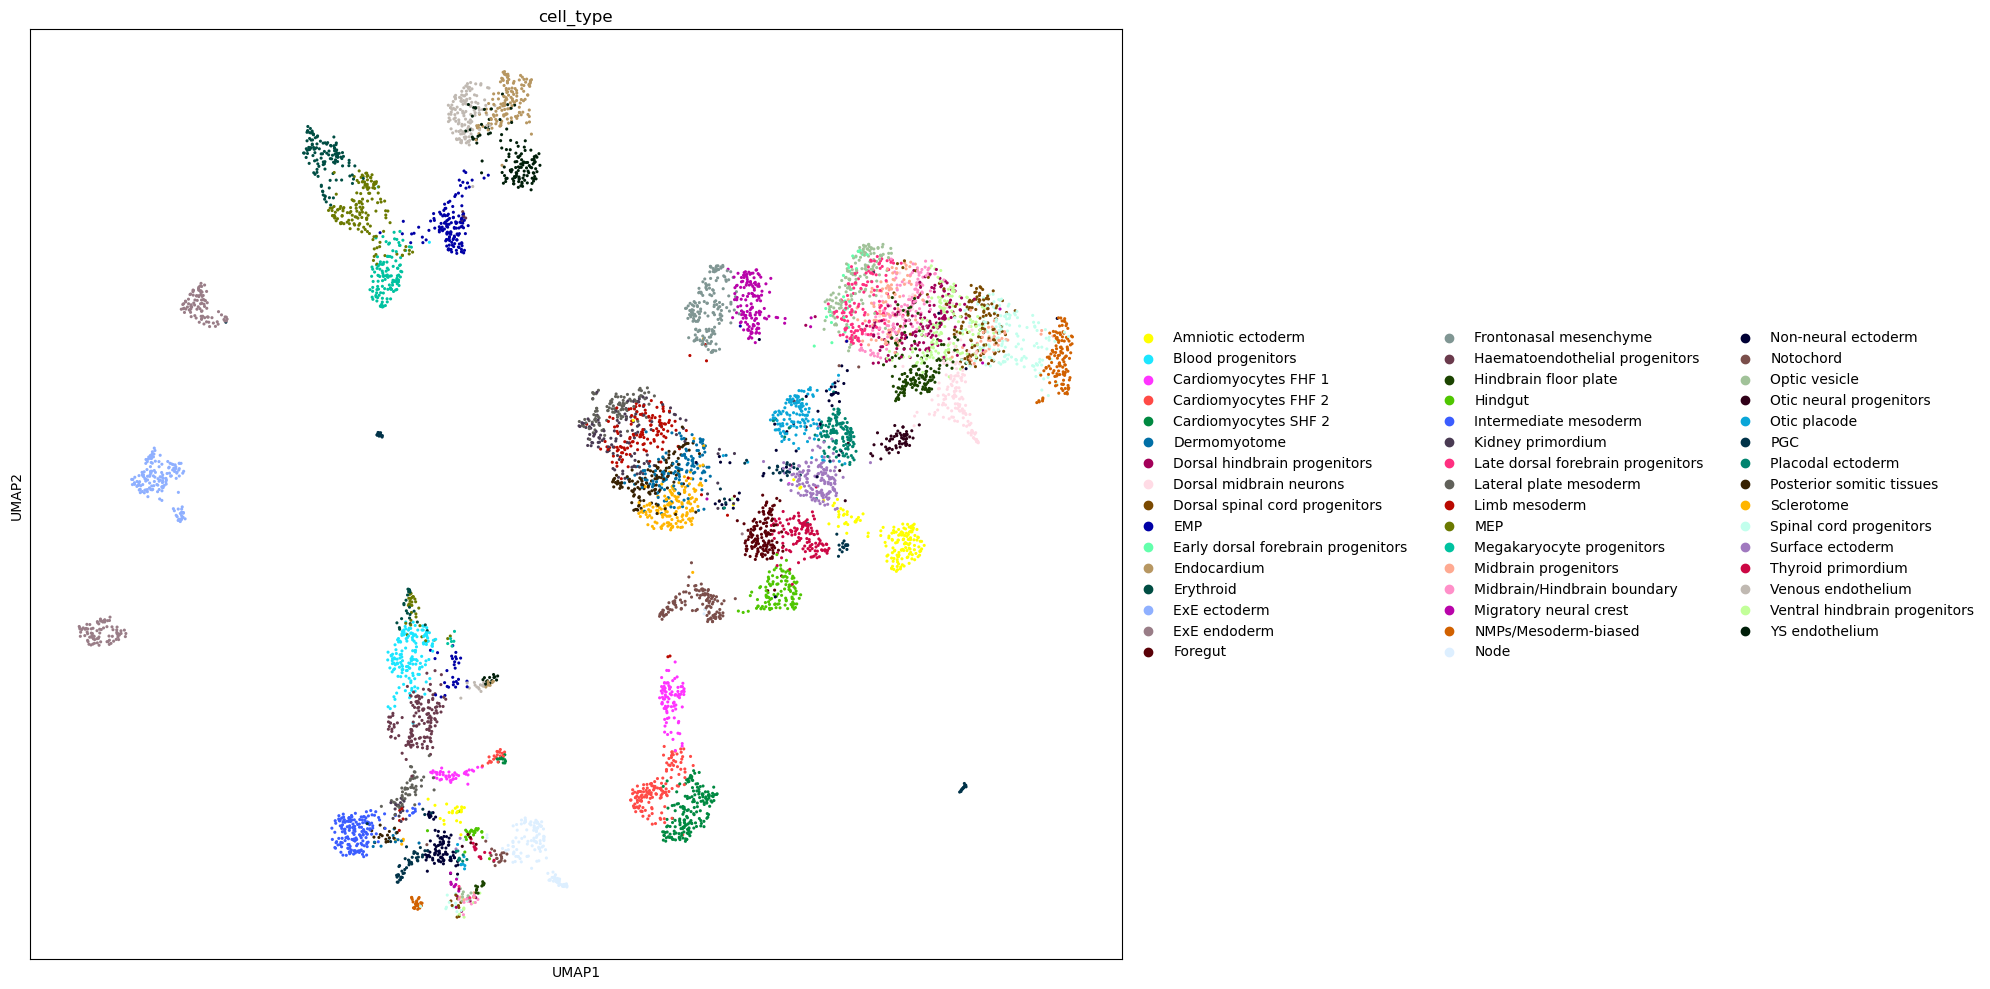

In [29]:
fig = sc.pl.umap(
    adata_test,
    color="cell_type",
    size=20,
    show=False
)
fig = plt.gcf()
fig.set_figheight(10)
fig.set_figwidth(20)

plt.tight_layout()

/var/folders/yw/486n_std62vfzrxvh1t8_94m0000gn/T/ipykernel_49432/3420815362.py:15: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


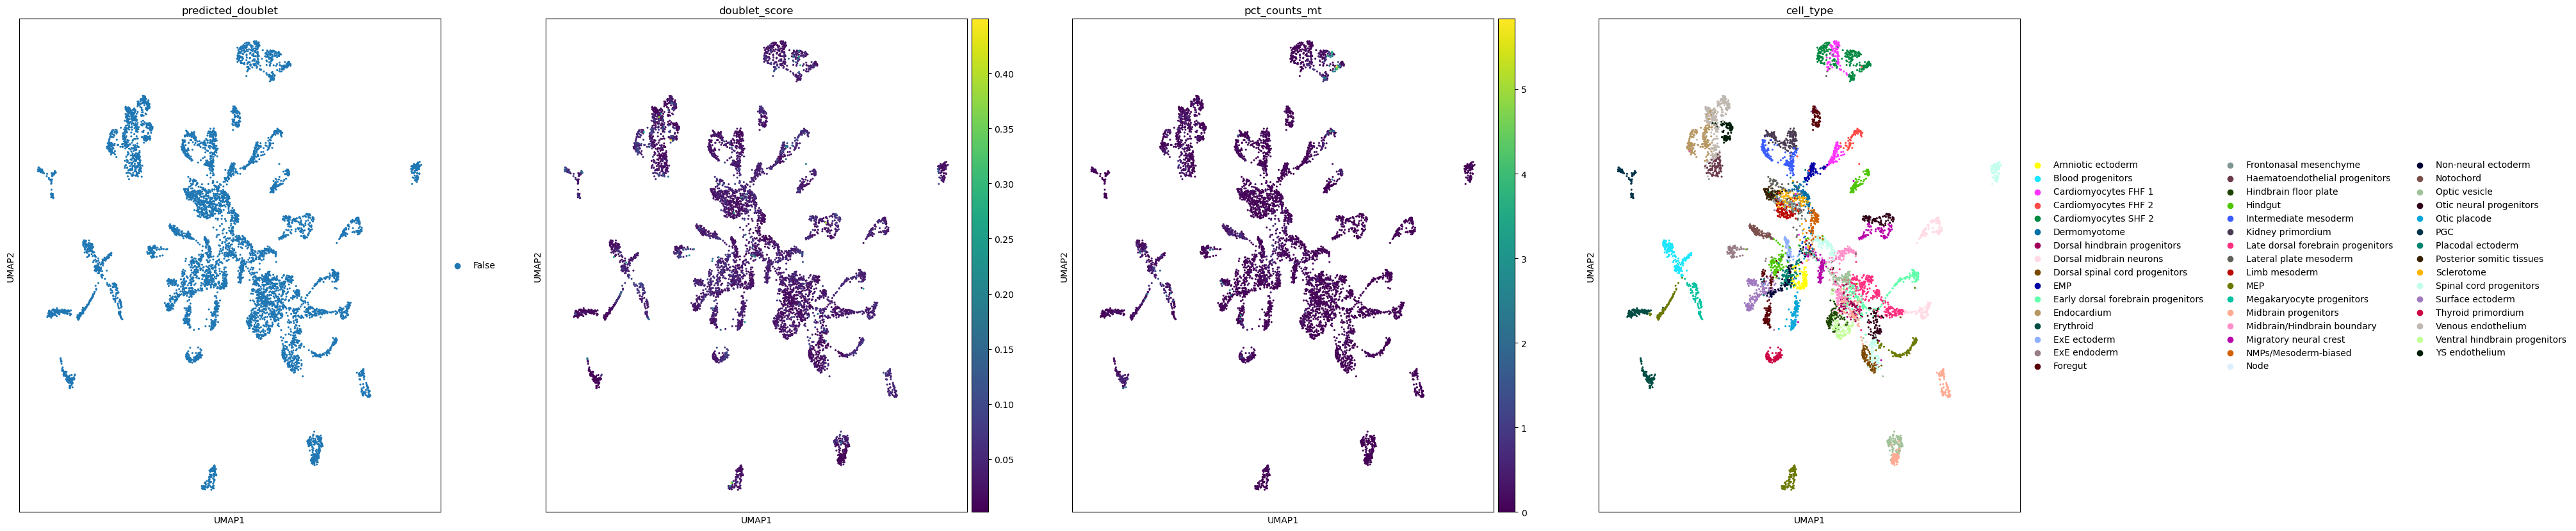

In [30]:
fig = sc.pl.umap(
    adata_train,
    color=['predicted_doublet',
           'doublet_score',
           'pct_counts_mt',
           'cell_type'
           ],
    size=20,
    show=False
)
fig = plt.gcf()
fig.set_figheight(10)
fig.set_figwidth(40)

plt.tight_layout()

/var/folders/yw/486n_std62vfzrxvh1t8_94m0000gn/T/ipykernel_49432/1925709864.py:15: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


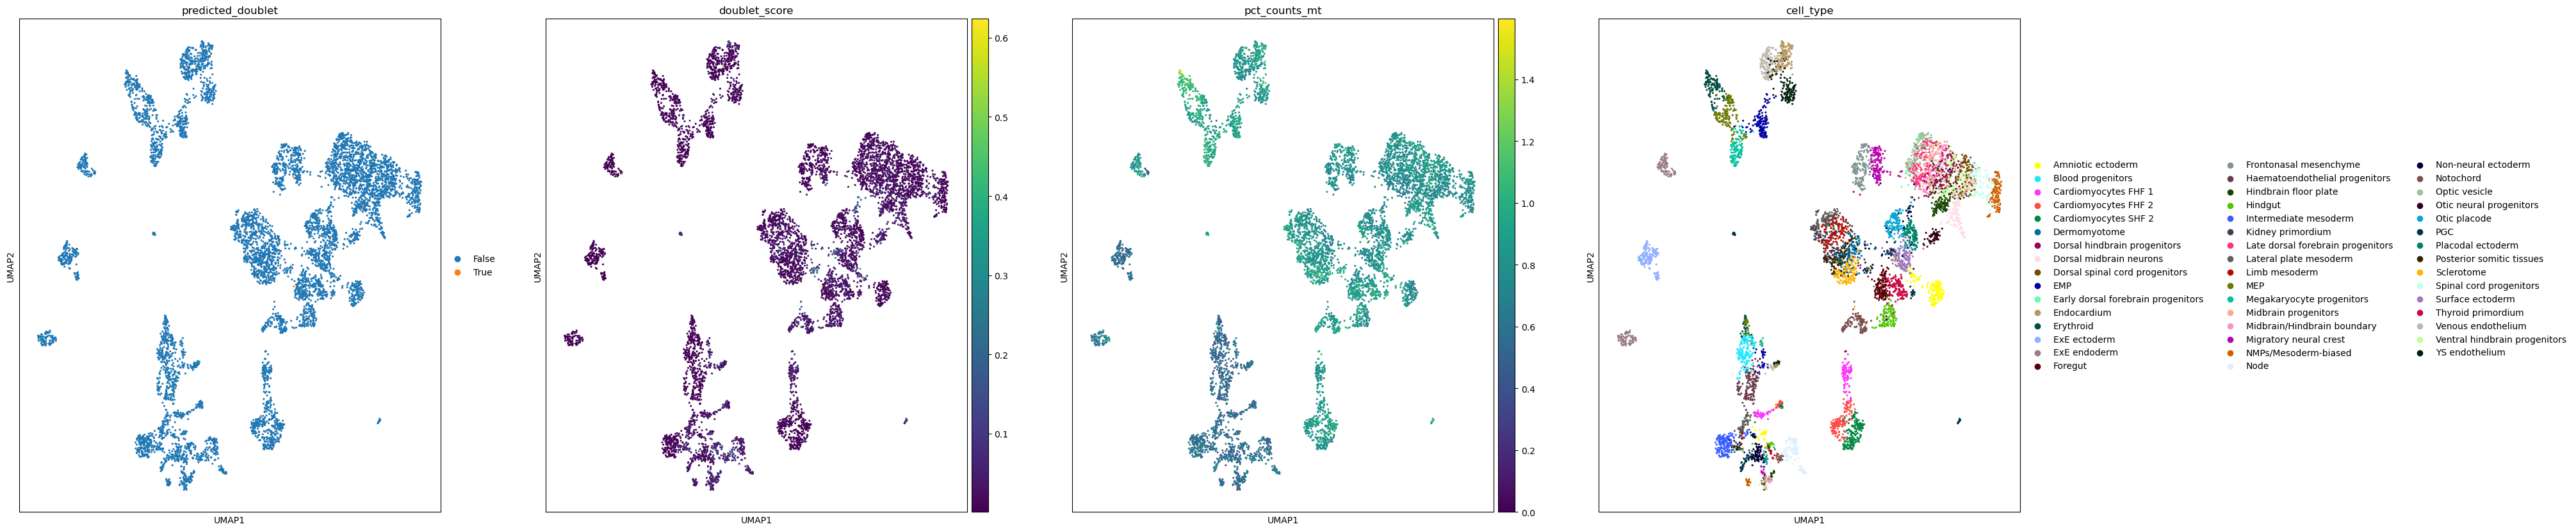

In [31]:
fig = sc.pl.umap(
    adata_test,
    color=['predicted_doublet',
           'doublet_score',
           'pct_counts_mt',
           'cell_type'
           ],
    size=20,
    show=False
)
fig = plt.gcf()
fig.set_figheight(10)
fig.set_figwidth(40)

plt.tight_layout()

In [32]:
print(adata_train.obs['predicted_doublet'].sum())
print(adata_test.obs['predicted_doublet'].sum())

0
4


In [33]:
print(adata_test[adata_test.obs['predicted_doublet']==True].obs_names)
adata_test_filtered = adata_test[adata_test.obs['predicted_doublet']==False].copy()

Index(['374498', '200200', '139382', '345588'], dtype='object')


In [34]:
context_length = 2048

In [35]:
ranked_indexes_each_row_train = np.flip(np.argsort(adata_train.X, axis=1), axis=1)
top_indexes_each_row_one_based_train = ranked_indexes_each_row_train[:,0:context_length]+1
cls_array_train = np.zeros((top_indexes_each_row_one_based_train.shape[0],1))

ranked_indexes_each_row_test = np.flip(np.argsort(adata_test_filtered.X, axis=1), axis=1)
top_indexes_each_row_one_based_test = ranked_indexes_each_row_test[:,0:context_length]+1
cls_array_test = np.zeros((top_indexes_each_row_one_based_test.shape[0],1))
Xtrain = np.concatenate((cls_array_train, top_indexes_each_row_one_based_train),axis=1)
Xtest = np.concatenate((cls_array_test, top_indexes_each_row_one_based_test),axis=1)

In [36]:
cell_type_codes_train = adata_train.obs['cell_type'].astype('category').cat.codes
cat_label_mapping = {v:k for (k,v) in set(zip(cell_type_codes_train, adata_train.obs['cell_type']))}
cell_type_codes_test = adata_test_filtered.obs['cell_type'].map(cat_label_mapping)
Ytrain = cell_type_codes_train.values
Ytest = cell_type_codes_test.values

In [37]:
Xval, Xtest_final, Yval, Ytest_final = train_test_split(Xtest, Ytest, test_size=0.4, random_state = 17)

In [ ]:
np.save('../data/Xtrain_base.npy', Xtrain)
np.save('../data/Ytrain_base.npy', Ytrain)

np.save('../data/Xval_base.npy', Xval)
np.save('../data/Yval_base.npy', Yval)

np.save('../data/Xtest_base.npy', Xtest_final)
np.save('../data/Ytest_base.npy', Ytest_final)

In [40]:
vocab = list(adata_train.var_names)
vocab = ['<CLS>'] + vocab
pd.Series(vocab).to_csv('../data/vocab.csv', index=True, header=False)

In [39]:
new_context_length = 1024

In [42]:
ranked_indexes_each_row_train = np.flip(np.argsort(adata_train.X, axis=1), axis=1)
ranked_indexes_each_row_train_previous = np.flip(np.argsort(adata_train.layers['X_previous'], axis=1), axis=1)

top_indexes_each_row_two_based_train = ranked_indexes_each_row_train[:,0:new_context_length]+2
top_indexes_each_row_two_based_train_previous = ranked_indexes_each_row_train_previous[:,0:new_context_length]+2

cls_array_train = np.zeros((top_indexes_each_row_two_based_train.shape[0],1))
sep_array_train = np.ones((top_indexes_each_row_two_based_train.shape[0],1))

ranked_indexes_each_row_test = np.flip(np.argsort(adata_test_filtered.X, axis=1), axis=1)
ranked_indexes_each_row_test_previous = np.flip(np.argsort(adata_test_filtered.layers['X_previous'], axis=1), axis=1)

top_indexes_each_row_two_based_test = ranked_indexes_each_row_test[:,0:new_context_length]+2
top_indexes_each_row_two_based_test_previous = ranked_indexes_each_row_test_previous[:,0:new_context_length]+2

cls_array_test = np.zeros((top_indexes_each_row_two_based_test.shape[0],1))
sep_array_test = np.ones((top_indexes_each_row_two_based_test.shape[0],1))


Xtrain_w_previous = np.concatenate((cls_array_train, sep_array_train, top_indexes_each_row_two_based_train, top_indexes_each_row_two_based_train_previous),axis=1)
Xtest_w_previous = np.concatenate((cls_array_test, sep_array_test, top_indexes_each_row_two_based_test, top_indexes_each_row_two_based_test_previous),axis=1)

In [43]:
Xval_w_previous, Xtest_w_previous_final, Yval_w_previous, Ytest_w_previous_final = train_test_split(Xtest_w_previous, Ytest, test_size=0.4, random_state = 17)

In [44]:
np.save('../data/Xtrain_w_previous.npy', Xtrain_w_previous)
np.save('../data/Ytrain_w_previous.npy', Ytrain)

np.save('../data/Xval_w_previous.npy', Xval_w_previous)
np.save('../data/Yval_w_previous.npy', Yval_w_previous)

np.save('../data/Xtest_w_previous.npy', Xtest_w_previous_final)
np.save('../data/Ytest_w_previous.npy', Ytest_w_previous_final)

In [46]:
new_vocab = list(adata_train.var_names)
vocab = ['<CLS>', '<SEP>'] + new_vocab
pd.Series(vocab).to_csv('../data/new_vocab.csv', index=True, header=False)

In [39]:
(adata_train.var_names==adata_test.var_names).sum()

np.int64(27037)

In [41]:
cat_label_mapping

{'Early dorsal forebrain progenitors': 10,
 'PGC': 37,
 'Endocardium': 11,
 'Venous endothelium': 44,
 'Spinal cord progenitors': 41,
 'Node': 31,
 'Notochord': 33,
 'Ventral hindbrain progenitors': 45,
 'Midbrain/Hindbrain boundary': 28,
 'Dorsal midbrain neurons': 7,
 'Sclerotome': 40,
 'YS endothelium': 46,
 'ExE ectoderm': 13,
 'Limb mesoderm': 24,
 'Kidney primordium': 21,
 'Midbrain progenitors': 27,
 'Frontonasal mesenchyme': 16,
 'Megakaryocyte progenitors': 26,
 'Amniotic ectoderm': 0,
 'Hindbrain floor plate': 18,
 'Otic placode': 36,
 'Posterior somitic tissues': 39,
 'Dorsal spinal cord progenitors': 8,
 'Cardiomyocytes SHF 2': 4,
 'Surface ectoderm': 42,
 'EMP': 9,
 'Lateral plate mesoderm': 23,
 'Placodal ectoderm': 38,
 'Otic neural progenitors': 35,
 'Intermediate mesoderm': 20,
 'Cardiomyocytes FHF 2': 3,
 'Haematoendothelial progenitors': 17,
 'Blood progenitors': 1,
 'ExE endoderm': 14,
 'Erythroid': 12,
 'Hindgut': 19,
 'Dermomyotome': 5,
 'Foregut': 15,
 'Optic ves

In [42]:
pd.DataFrame([(cat_label_mapping[k],k) for k in cat_label_mapping]).sort_values(by=1).to_csv('../data/cat_label_mapping.csv',index=False, header=False)